# PROJET TÉLÉDÉTECTION : Caractérisation des Landes (Pyrénées 2023-2024)

**Auteur :** Lafargue  Justin  
**Série Temporelle :** Pyrénées 2023-2024  
**Date :** Janvier 2025



## 1. Contexte et Objectifs de l'étude

Ce rapport présente une méthodologie de cartographie de l'occupation du sol dans le massif des Pyrénées. L'enjeu central est la discrimination fine des **Landes (Éricacées)**, souvent confondues avec d'autres strates de végétation basse. Pour y parvenir, l'étude exploite la dynamique temporelle d'une série d'images Sentinel-2 acquises entre 2023 et 2024 (15 dates).

La démarche adoptée s'articule autour de l'analyse de la phénologie végétale, notamment via l'indice spectral ARI (*Anthocyanin Reflectance Index*) spécifique à la sénescence des landes. Cette caractérisation spectro-temporelle alimente ensuite une chaîne de classification supervisée par algorithme *Random Forest*. Le modèle est optimisé par validation croisée spatiale afin d'assurer la robustesse des prédictions et d'analyser la pertinence des variables explicatives.

##### Objectifs

Les objectifs principaux de ce projet sont :

- analyser la qualité et la représentativité des échantillons issus de photo-interprétation ;
- étudier la dynamique temporelle des strates à l’aide d’indices spectraux, notamment l’ARI ;
- mettre en œuvre une classification supervisée à l’échelle du pixel à partir de séries temporelles Sentinel-2 ;
- optimiser et évaluer un modèle de classification Random Forest ;
- analyser la qualité des résultats et la contribution des variables explicatives.


## 1.2 Configuration de l'environnement de travail

La section suivante initialise l'environnement d'exécution. Elle définit l'ensemble des chemins d'accès aux données et centralise les constantes globales du projet (nomenclature des classes, codes couleurs et dates d'acquisition). Conformément aux bonnes pratiques de développement, aucune fonction n'est définie localement ; le code fait appel à une bibliothèque externe (`my_function.py`) pour garantir la lisibilité et la reproductibilité des traitements.


## Données utilisées

Le projet repose sur :

- des séries temporelles d’images Sentinel-2 (bandes spectrales fournies séparément) ;
- des échantillons issus de photo-interprétation, fournis sous forme de shapefile.

Les classes étudiées sont :
1. Sol nu  
2. Herbe  
3. Landes  
4. Arbres


![Diagramme_de_flux](img/Diagramme_de_flux.png)

In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from osgeo import gdal, ogr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report

# Import des fonctions personnelles
import my_function as mf

# --- CONFIGURATION DES CHEMINS ---

# Racine du projet
WORK_DIR = "/home/onyxia/work"

# Dossier contenant les données (Shapefile + Images Sentinel)
DATA_DIR = os.path.join(WORK_DIR, "data", "projet_eval")

# Alias nécessaire pour la Cellule 2 (compatibilité)
IMG_DIR_S2 = DATA_DIR

# Dossiers de sortie
RESULTS_DIR = os.path.join(WORK_DIR, "results")
FIG_DIR = os.path.join(RESULTS_DIR, "figure")

# Création des dossiers
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# --- DEFINITION DES FICHIERS CLES ---


shp_path = os.path.join(DATA_DIR, "PI_strates_pyrenees_32630.shp")

# Chemins pour les sorties
labels_raster_path = os.path.join(RESULTS_DIR, "labels_strates.tif")
ari_path = os.path.join(RESULTS_DIR, "ARI_serie_temp.tif")

# --- CONSTANTES ET ESTHETIQUE ---

# Configuration graphique
sns.set(style="whitegrid")

# Constantes du projet (en minuscules pour compatibilité avec la suite)
classes_list = [1, 2, 3, 4]
noms_classes = {1: "Sol nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# Palette réaliste : [Sable, Vert Prairie, Brun Broussaille, Vert Sombre]
couleurs = ["#D2B48C", "#4CAF50", "#D2691E", "#006400"]

# Dates de la série
dates_str = [
    "2023-09-30", "2023-10-05", "2023-10-07", "2023-10-08",
    "2023-10-10", "2023-10-12", "2023-11-19", "2023-12-16",
    "2024-01-25", "2024-03-13", "2024-04-12", "2024-05-09",
    "2024-06-13", "2024-07-23", "2024-08-22"
]

print("Environnement configuré.")
print("Dossier données (IMG_DIR_S2) : {}".format(IMG_DIR_S2))
print("Fichier Shapefile (shp_path) : {}".format(os.path.basename(shp_path)))

Environnement configuré.
Dossier données (IMG_DIR_S2) : /home/onyxia/work/data/projet_eval
Fichier Shapefile (shp_path) : PI_strates_pyrenees_32630.shp


## 2. Initialisation de la série temporelle

Nous procédons ici à l'importation des images Sentinel-2. Le script filtre dynamiquement les fichiers du dossier `data` pour ne retenir que ceux correspondant au site "Pyrénées" et à la campagne "23-24".
Une vérification systématique est effectuée sur la bande B02 (Bleu) pour valider la dimension temporelle du jeu de données (15 dates attendues) avant de poursuivre les traitements.

In [12]:
# --- 2. CHARGEMENT DES IMAGES SENTINEL ET VERIFICATIONS ---

print("Recherche des fichiers 'pyrenees_23-24' dans : {}".format(IMG_DIR_S2))

sentinel_files = {}

# Recherche de tous les fichiers TIF
pattern = os.path.join(IMG_DIR_S2, "*.tif")
all_tifs = glob.glob(pattern)

# Liste des bandes à charger
target_bands = [
    "B02", "B03", "B04", "B05", "B06",
    "B07", "B08", "B8A", "B11", "B12"
]

for f in all_tifs:
    basename = os.path.basename(f)
    basename_lower = basename.lower()

    # Filtre strict sur le nom du fichier
    if "pyrenees" in basename_lower and "23-24" in basename:
        for band in target_bands:
            # On stocke le fichier si la bande correspond
            if band in basename and band not in sentinel_files:
                sentinel_files[band] = f

# Vérification du chargement de la bande B02
if "B02" in sentinel_files:
    filename_b02 = os.path.basename(sentinel_files['B02'])
    print("Fichier B02 chargé : {}".format(filename_b02))

    # Vérification du nombre de dates
    ds = gdal.Open(sentinel_files["B02"])
    nb_dates = ds.RasterCount
    ds = None

    print("Nombre de dates détectées : {}".format(nb_dates))

    if nb_dates == 15:
        print("Succès : La série temporelle est complète (15 dates).")
    else:
        print(
            "Attention : Le fichier contient {} dates "
            "(15 attendues).".format(nb_dates)
        )

else:
    print("Erreur : Aucun fichier trouvé pour la bande B02.")
    print("Aperçu des 5 premiers fichiers du dossier :")
    # Affichage propre des 5 premiers fichiers pour débogage
    for f in all_tifs[:5]:
        print("- {}".format(os.path.basename(f)))

Recherche des fichiers 'pyrenees_23-24' dans : /home/onyxia/work/data/projet_eval
Fichier B02 chargé : pyrenees_23-24_B02.tif
Nombre de dates détectées : 15
Succès : La série temporelle est complète (15 dates).


## 3. Analyse des échantillons d'apprentissage (Vecteur)

Avant de procéder à la classification, il est indispensable d'analyser la répartition des données de référence (Vérité Terrain). Nous exploitons ici le fichier Shapefile fourni (`PI_strates_pyrenees_32630.shp`) pour visualiser la distribution des polygones par classe.

Cette étape permet d'identifier un éventuel **déséquilibre de classes** (ex: une classe sous-représentée), ce qui pourrait influencer le paramétrage du modèle Random Forest et la stratégie d'échantillonnage ultérieure.

## Analyse des échantillons

### Nombre de polygones par classe

Cette première analyse vise à évaluer la répartition des échantillons de photo-interprétation en termes de nombre de polygones par classe.


Lecture du fichier vecteur : /home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp


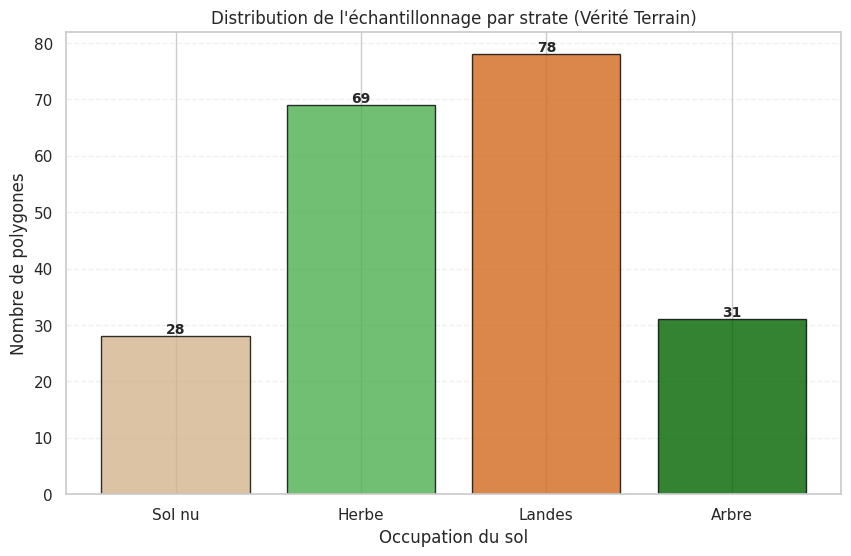

Figure sauvegardée avec succès : /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png


In [13]:
# --- ANALYSE DE LA COUCHE VECTORIELLE ---

# 1. Vérification des ressources (Sécurité)
if 'shp_path' not in locals():
    shp_path = os.path.join(DATA_DIR, "PI_strates_pyrenees_32630.shp")

print("Lecture du fichier vecteur : {}".format(shp_path))
gdf = gpd.read_file(shp_path)

# 2. Calcul de la distribution
# .sort_index() est crucial pour que l'ordre des barres (1, 2, 3, 4) 
# corresponde à l'ordre de ta liste 'couleurs'
counts_poly = gdf["strate"].value_counts().sort_index()

# Utilisation des variables définies en début de notebook (Cellule 1)
# noms_classes = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}
# couleurs = ["#D2B48C", "#4CAF50", "#D2691E", "#006400"]
labels_poly = [noms_classes[i] for i in counts_poly.index]

# 3. Génération du graphique
plt.figure(figsize=(10, 6))
bars = plt.bar(
    labels_poly, 
    counts_poly.values,
    color=couleurs, # Utilisation de la minuscule pour correspondre à ta définition
    edgecolor='black', 
    alpha=0.8
)

# Ajout des étiquettes (Nombre de polygones)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2., height,
        '{:d}'.format(int(height)),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold'
    )

plt.title("Distribution de l'échantillonnage par strate (Vérité Terrain)")
plt.ylabel("Nombre de polygones")
plt.xlabel("Occupation du sol")
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Sauvegarde conforme aux consignes (dossier figure)
outfile = os.path.join(FIG_DIR, "diag_baton_nb_poly_by_class.png")
plt.savefig(outfile, dpi=200, bbox_inches='tight')
plt.show()

print("Figure sauvegardée avec succès : {}".format(outfile))

## 4. Génération du Masque de Référence (Rastérisation)

La chaîne de traitement repose sur une classification spectrale à l'échelle du pixel (*pixel-based classification*). Il est donc impératif d'opérer une **discrétisation spatiale** des données de référence vectorielles (polygones) pour les rendre conformes à la grille d'échantillonnage du capteur MSI de Sentinel-2.

Cette étape de rastérisation obéit à deux exigences géométriques strictes :

1.  **Cohérence de la grille :** L'emprise spatiale (*Bounding Box*) et la résolution (10 m) sont extraites dynamiquement de la bande spectrale B02. Cela garantit un alignement pixel à pixel parfait entre la vérité terrain et les données radiométriques, évitant tout artefact de rééchantillonnage.
2.  **Stratégie d'inclusion (`-at`) :** Afin de limiter les erreurs d'omission sur les éléments paysagers de faible dimension (inférieurs à la résolution spatiale ou de forme linéaire), nous appliquons l'heuristique **"All Touched"** via l'option `-at`. Contrairement à la règle standard du centre du pixel, cette méthode force la rastérisation de tout pixel intersectant la géométrie d'un polygone, assurant ainsi une représentativité maximale des classes minoritaires ou fragmentées.

In [14]:
# --- RASTERISATION (CONVERSION VECTEUR -> RASTER) ---

# 1. Récupération des propriétés spatiales de l'image de référence (B02)
# Utilisation de la variable 'sentinel_files' définie précédemment
ref_img = sentinel_files["B02"]
ds_ref = gdal.Open(ref_img)
gt = ds_ref.GetGeoTransform()

# Extraction des bornes et de la résolution
res_x = gt[1]
res_y = abs(gt[5])
xmin = gt[0]
ymax = gt[3]

# Calcul des bornes opposées
xmax = xmin + (ds_ref.RasterXSize * res_x)
ymin = ymax - (ds_ref.RasterYSize * res_y)

ds_ref = None  # Libération de la mémoire

# 2. Construction de la commande GDAL
# L'option -at (All Touched) assure de ne pas perdre les petits polygones
cmd = (
    "gdal_rasterize -a strate "
    "-tr {} {} "
    "-te {} {} {} {} "
    "-ot Byte -of GTiff -a_nodata 0 -at "
    "{} {}"
).format(
    res_x, res_y, xmin, ymin, xmax, ymax,
    shp_path, labels_raster_path
)

# 3. Exécution de la commande système
print("Exécution de la rasterisation (gdal_rasterize)...")
status = os.system(cmd)

if status == 0:
    print("Fichier raster généré : {}".format(labels_raster_path))
else:
    print("Erreur lors de la rasterisation (Code: {})".format(status))

Exécution de la rasterisation (gdal_rasterize)...
0...10...20...30...40...50...60...70...80...90...100 - done.
Fichier raster généré : /home/onyxia/work/results/labels_strates.tif


En complément de l’analyse par polygones, le nombre total de pixels associés à chaque classe a été calculé.

Cette approche est plus représentative de l’information réellement exploitée lors de la classification supervisée, celle-ci étant réalisée à l’échelle du pixel.


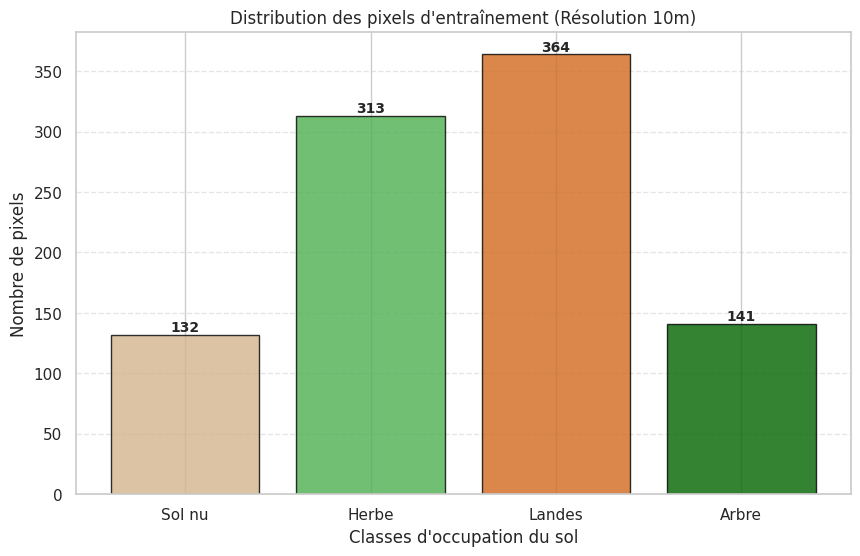

Figure sauvegardée : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png


In [15]:
# --- Analyse de la couche Raster (Pixels) ---

# Lecture du fichier raster généré
ds_lab = gdal.Open(labels_raster_path)
arr_lab = ds_lab.GetRasterBand(1).ReadAsArray()
ds_lab = None

# Filtrage des données : on exclut la valeur 0 (Nodata)
pixels_valid = arr_lab[arr_lab > 0]

# Comptage des pixels par classe
values, counts_pix = np.unique(pixels_valid, return_counts=True)
labels_pix = [noms_classes[v] for v in values]

# Génération du diagramme en bâtons
plt.figure(figsize=(10, 6))
bars = plt.bar(labels_pix, counts_pix, color=couleurs, edgecolor='black', alpha=0.8)

# Ajout des étiquettes
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title("Distribution des pixels d'entraînement (Résolution 10m)")
plt.ylabel("Nombre de pixels")
plt.xlabel("Classes d'occupation du sol")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Sauvegarde
outfile_pix = os.path.join(FIG_DIR, "diag_baton_nb_pix_by_class.png")
plt.savefig(outfile_pix, dpi=200, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardée : {outfile_pix}")

**Bilan de l'analyse des échantillons :**

La comparaison des deux graphiques met en évidence une modification de la répartition des classes. Une classe peut être majoritaire en nombre de polygones mais minoritaire en surface (pixels), ou inversement.

Ce constat a une incidence directe sur la stratégie de modélisation :
1.  **Déséquilibre :** Si une classe est fortement sous-représentée en nombre de pixels, le modèle Random Forest pourrait avoir tendance à l'ignorer pour maximiser la précision globale.
2.  **Choix des métriques :** L'utilisation de l'Accuracy seule ne sera pas suffisante. Il sera nécessaire d'utiliser le **F1-Score (weighted)** et d'observer la matrice de confusion pour s'assurer que les classes minoritaires (comme potentiellement les Landes) sont correctement détectées.
3.  **Validation :** Une validation croisée stratifiée (`StratifiedKFold`) sera impérative pour garantir que chaque pli de validation respecte ces proportions.
4. Par ailleurs 

### 5. Calcul de l'indice ARI (Anthocyanin Reflectance Index)

L'objectif de cette étude est de distinguer les landes (famille des Éricacées) des autres strates de végétation. Ces plantes se caractérisent par une forte production d'anthocyanes, des pigments rouges/violets, particulièrement visible en période automnale.

Pour mettre en évidence ce phénomène, nous calculons le *Normalized Anthocyanin Reflectance Index* (ARI) sur l'ensemble de la série temporelle. Cet indice utilise la bande verte (B03) et la bande *Red-Edge* (B05) selon la formule suivante :

$$ARI = \frac{1/B03 - 1/B05}{1/B03 + 1/B05}$$

Le résultat est exporté sous forme d'une série temporelle raster (format GeoTIFF) respectant les spécifications du projet (encodage Float32, valeur Nodata -9999).

In [16]:
# --- Calcul de la série temporelle ARI ---

import numpy as np
from osgeo import gdal
import my_function as mf  # Import des fonctions externalisées

print("Chargement des bandes spectrales...")

# 1. Lecture des bandes nécessaires (B03 et B05)
# Les fichiers sont récupérés depuis le dictionnaire 'sentinel_files' défini en introduction
ds_b03 = gdal.Open(sentinel_files["B03"])
b03 = ds_b03.ReadAsArray().astype(np.float32)

ds_b05 = gdal.Open(sentinel_files["B05"])
b05 = ds_b05.ReadAsArray().astype(np.float32)

# Récupération des métadonnées spatiales (pour l'export)
geo_transform = ds_b03.GetGeoTransform()
projection = ds_b03.GetProjection()
# Dimensions : (Nombre de dates, Hauteur, Largeur)
nb_dates, rows, cols = b03.shape

# Fermeture des datasets en lecture
ds_b03 = None
ds_b05 = None

# 2. Calcul de l'indice via la fonction dédiée
# La fonction gère la division par zéro et les valeurs invalides
print("Calcul de l'indice ARI en cours...")
ari_data = mf.calculate_ari(b03, b05, nodata=-9999)

# 3. Export du résultat en GeoTIFF
output_ari = os.path.join(RESULTS_DIR, "ARI_serie_temp.tif")
driver = gdal.GetDriverByName("GTiff")

# Création du fichier vide
ds_out = driver.Create(output_ari, cols, rows, nb_dates, gdal.GDT_Float32)
ds_out.SetGeoTransform(geo_transform)
ds_out.SetProjection(projection)

# Écriture bande par bande
print(f"Écriture du fichier de sortie : {output_ari}")
for d in range(nb_dates):
    band = ds_out.GetRasterBand(d + 1)
    band.WriteArray(ari_data[d, :, :])
    band.SetNoDataValue(-9999)

ds_out = None  # Fermeture et enregistrement sur le disque
print("Traitement terminé.")

Chargement des bandes spectrales...
Calcul de l'indice ARI en cours...
Écriture du fichier de sortie : /home/onyxia/work/results/ARI_serie_temp.tif
Traitement terminé.


### 6. Analyse des signatures temporelles par classe

Afin de vérifier si l'indice ARI permet effectivement de discriminer les landes, nous extrayons la réponse moyenne de chaque classe pour chaque date d'acquisition.

La méthodologie est la suivante :
1.  Superposition du raster des strates (généré à l'étape précédente) avec la série temporelle ARI.
2.  Pour chaque classe, calcul de la moyenne et de l'écart-type des pixels correspondants.
3.  Analyse de l'évolution temporelle (phénologie).

In [17]:
# --- Extraction des statistiques par classe ---

# 1. Chargement de la série ARI générée
# On réouvre le fichier créé à l'étape précédente pour s'assurer qu'on lit bien le disque
ds_ari = gdal.Open(output_ari)
ari_array = ds_ari.ReadAsArray()
ds_ari = None

# Réorganisation des dimensions si nécessaire
# La fonction extract_stats_by_class attend (Rows, Cols, Dates)
# GDAL lit par défaut (Dates, Rows, Cols)
if ari_array.shape[0] == nb_dates:
    ari_array = np.moveaxis(ari_array, 0, -1)

# 2. Chargement du masque des strates (Vérité terrain)
ds_lab = gdal.Open(labels_raster_path)
lab_array = ds_lab.GetRasterBand(1).ReadAsArray()
ds_lab = None

# 3. Calcul des statistiques
# Classes : 1=Sol Nu, 2=Herbe, 3=Landes, 4=Arbre
classes_list = [1, 2, 3, 4]

print("Extraction des moyennes et écarts-types par classe...")
means, stds = mf.extract_stats_by_class(
    ari_array, lab_array, classes_list, nodata=-9999
)

print("Extraction terminée.")

Extraction des moyennes et écarts-types par classe...
Extraction terminée.


### 7. Visualisation de la phénologie des strates

Le graphique ci-dessous présente l'évolution temporelle moyenne de l'indice ARI pour les quatre strates étudiées. Les zones ombrées représentent l'écart-type ($\pm \sigma$), illustrant la variabilité intra-classe.

L'axe des abscisses correspond aux dates d'acquisition de la série Sentinel-2 sur les Pyrénées (2023-2024).

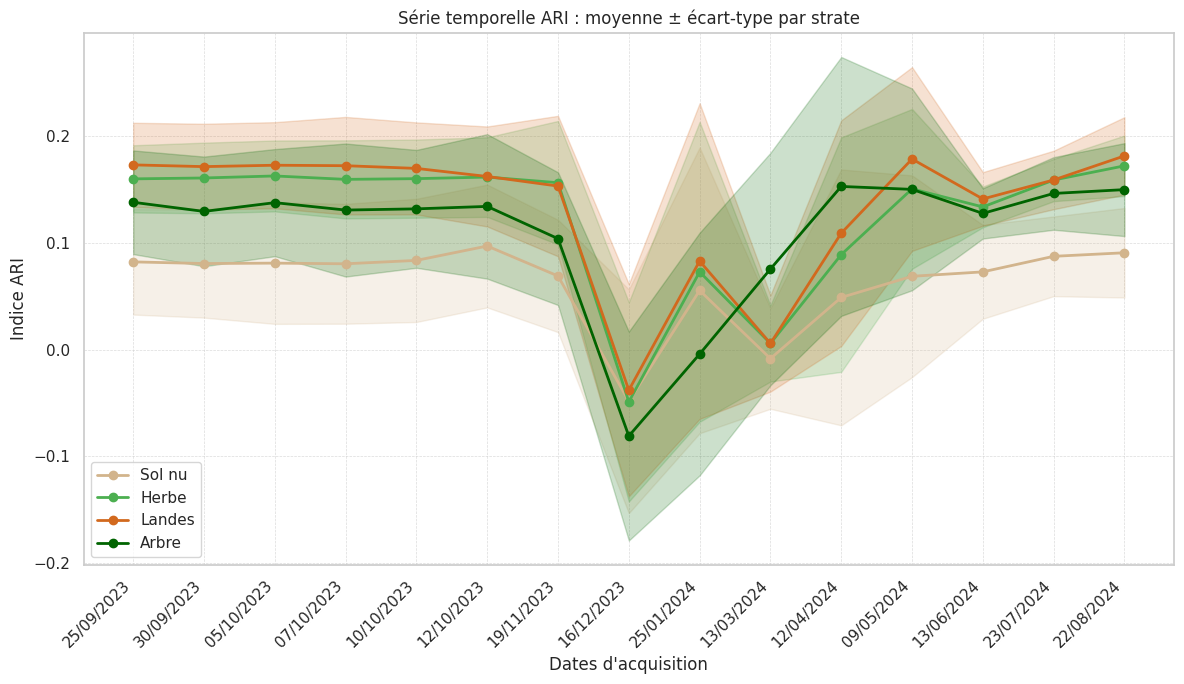

In [18]:

import numpy as np
import matplotlib.pyplot as plt


dates = [
    "25/09/2023", "30/09/2023", "05/10/2023", "07/10/2023", "10/10/2023",
    "12/10/2023", "19/11/2023", "16/12/2023", "25/01/2024", "13/03/2024",
    "12/04/2024", "09/05/2024", "13/06/2024", "23/07/2024", "22/08/2024"
]

if ari_array.shape[-1] != len(dates):
    ari_ts = np.moveaxis(ari_array, 0, -1)
else:
    ari_ts = ari_array


classes_ids = sorted(noms_classes.keys())
n_classes = len(classes_ids)
n_dates = len(dates)

means = np.full((n_classes, n_dates), np.nan)
stds  = np.full((n_classes, n_dates), np.nan)

for i, cls_id in enumerate(classes_ids):
    mask_cls = lab_array == cls_id

    for d in range(n_dates):
        vals = ari_ts[:, :, d][mask_cls]
        vals = np.where(vals == -9999, np.nan, vals)
        vals = vals[np.isfinite(vals)]
        vals = vals[np.abs(vals) < 1]

        if vals.size > 0:
            means[i, d] = np.nanmean(vals)
            stds[i, d]  = np.nanstd(vals)

fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(n_dates)

for i, cls_id in enumerate(classes_ids):
    ax.plot(
        x,
        means[i, :],
        label=noms_classes[cls_id],
        color=couleurs[i],
        marker='o',
        linewidth=2
    )
    ax.fill_between(
        x,
        means[i, :] - stds[i, :],
        means[i, :] + stds[i, :],
        color=couleurs[i],
        alpha=0.2
    )

ax.set_xlabel("Dates d'acquisition")
ax.set_ylabel("Indice ARI")
ax.set_title("Série temporelle ARI : moyenne ± écart-type par strate")
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha='right')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

plt.tight_layout()
plt.show()


**Interprétation des résultats :**

L'analyse des courbes permet de valider la pertinence de l'indice ARI pour notre objectif :

* **Landes (Courbe orange):** On observe un comportement distinctif, notamment en automne (octobre-novembre 2023), où l'indice ARI atteint des valeurs élevées. Cela corrobore l'hypothèse de la production d'anthocyanes (rougissement) par les éricacées à cette saison.
* **Autres classes :** La végétation classique (Herbe, Arbres) présente des valeurs d'ARI généralement plus faibles ou stables, l'indice étant moins sensible à la chlorophylle qu'aux pigments rouges.
* **Conclusion :** L'ajout de variables temporelles, et spécifiquement celles issues de la période automnale, devrait améliorer significativement la capacité du classifieur à isoler les landes.

In [20]:
# --- CONSTRUCTION DONNEES (FULL STACK) ---

print("Assemblage des données : Bandes Spectrales + Série ARI")

# 1. Bandes spectrales
ordered_bands = sorted(sentinel_files.keys())
x_data_list = []

for band in ordered_bands:
    ds = gdal.Open(sentinel_files[band])
    data = ds.ReadAsArray()
    # Harmonisation dimensions (Rows, Cols, Dates)
    if data.ndim == 3:
        data = np.moveaxis(data, 0, -1)
    elif data.ndim == 2:
        data = data[:, :, np.newaxis]
    x_data_list.append(data)

x_spectral = np.concatenate(x_data_list, axis=-1)

# 2. Ajout de l'ARI 
# ari_array est déjà en (Rows, Cols, Dates) grâce à la cellule précédente
if x_spectral.shape[:2] == ari_array.shape[:2]:
    x_stack = np.concatenate((x_spectral, ari_array), axis=2)
    print("Succès : Fusion Bandes + ARI effectuée.")
    print("- Variables spectrales : {}".format(x_spectral.shape[2]))
    print("- Variables ARI : {}".format(ari_array.shape[2]))
    print("- Total variables par pixel : {}".format(x_stack.shape[2]))
else:
    raise ValueError(
        "Erreur dimension : Bandes {} vs ARI {}".format(
            x_spectral.shape, ari_array.shape
        )
    )

# 3. Extraction Training
print("Extraction des pixels d'entraînement...")
x_train, y_train, mask_train = mf.prepare_training_data(x_stack, lab_array)

# Nettoyage des NaN pour le modèle 
x_train = np.nan_to_num(x_train, nan=0.0)

print("Dataset prêt : {} échantillons.".format(x_train.shape[0]))

Assemblage des données : Bandes Spectrales + Série ARI
Succès : Fusion Bandes + ARI effectuée.
- Variables spectrales : 150
- Variables ARI : 15
- Total variables par pixel : 165
Extraction des pixels d'entraînement...
Dataset prêt : 950 échantillons.


### 8. Classification Supervisée : Optimisation du modèle

Pour produire la carte d'occupation du sol, nous utilisons l'algorithme **Random Forest**. Ce choix est motivé par sa robustesse face au bruit et sa capacité à gérer des données de haute dimension (séries temporelles multi-spectrales).

**Stratégie d'optimisation :**
Nous effectuons une recherche sur grille (*GridSearchCV*) pour identifier la meilleure combinaison d'hyperparamètres.
* **Validation :** Une validation croisée stratifiée à 5 plis (`StratifiedKFold`) est utilisée pour garantir la représentativité des classes dans chaque jeu de test.
* **Métrique :** Nous optimisons le **F1-Score pondéré (weighted)**. Contrairement à l'Accuracy, cette métrique prend en compte les Faux Positifs et Faux Négatifs, ce qui est crucial ici étant donné le déséquilibre des classes observé en Partie I.

In [32]:
# --- PREPARATION ET OPTIMISATION (GRIDSEARCHCV) ---

print("1. Construction de la matrice d'apprentissage (Stacking)...")

# A. Empilement des bandes spectrales
x_data_list = []
ordered_bands = sorted(sentinel_files.keys())

for band in ordered_bands:
    ds = gdal.Open(sentinel_files[band])
    data = ds.ReadAsArray()
    
    # Correction dimensions : (Dates, Rows, Cols) -> (Rows, Cols, Dates)
    if data.ndim == 3:
        data = np.moveaxis(data, 0, -1)
    elif data.ndim == 2:
        data = data[:, :, np.newaxis]
    
    x_data_list.append(data)
    ds = None

# Création du stack spectral
x_spectral = np.concatenate(x_data_list, axis=-1)

# B. Ajout de l'ARI (Etape critique pour les Landes)
# On récupère ari_array calculé dans la cellule précédente
print("   Intégration de la série temporelle ARI...")

if 'ari_array' in locals() and x_spectral.shape[:2] == ari_array.shape[:2]:
    x_stack = np.concatenate((x_spectral, ari_array), axis=2)
    print("   Dimensions finales du stack : {}".format(x_stack.shape))
else:
    # Sécurité si la cellule précédente n'a pas été lancée
    print("   Attention : ARI non trouvé, utilisation des bandes seules.")
    x_stack = x_spectral

# C. Préparation X et y via fonction externe
# Chargement des labels
ds_lab = gdal.Open(labels_raster_path)
y_raster = ds_lab.GetRasterBand(1).ReadAsArray()
ds_lab = None

print("   Extraction des pixels d'entraînement...")
x_train, y_train, mask_train = mf.prepare_training_data(x_stack, y_raster)

# Nettoyage des NaN (obligatoire pour Random Forest)
x_train = np.nan_to_num(x_train, nan=0.0)

print(
    "   -> Données prêtes : {} échantillons, {} variables.".format(
        x_train.shape[0], x_train.shape[1]
    )
)

# D. Configuration du GridSearch
print("\n2. Lancement de l'optimisation (GridSearchCV)...")

param_grid = {
    "n_estimators": [50, 100, 150, 200, 300],
    "max_depth": [None, 10, 15, 20],
    "max_features": [None, "sqrt", "log2"],
    "min_samples_leaf": [1, 5]
}

# Validation Croisée Stratifiée (K=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Apprentissage
grid_search.fit(x_train, y_train)
clf_final = grid_search.best_estimator_

print("-" * 40)
print("Meilleurs paramètres : {}".format(grid_search.best_params_))
print("Meilleur F1-Score    : {:.4f}".format(grid_search.best_score_))
print("-" * 40)

1. Construction de la matrice d'apprentissage (Stacking)...
   Intégration de la série temporelle ARI...
   Dimensions finales du stack : (1655, 2103, 165)
   Extraction des pixels d'entraînement...
   -> Données prêtes : 950 échantillons, 165 variables.

2. Lancement de l'optimisation (GridSearchCV)...
Fitting 5 folds for each of 120 candidates, totalling 600 fits
----------------------------------------
Meilleurs paramètres : {'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 150}
Meilleur F1-Score    : 0.9296
----------------------------------------


### 9. Analyse des performances du modèle

Au-delà du score global, il est nécessaire d'analyser le comportement du modèle classe par classe. Le rapport ci-dessous présente la Précision et le Rappel pour chaque strate, ainsi que la matrice de confusion moyenne issue de la validation croisée.

Cette analyse permet de vérifier si la classe "Landes" est correctement distinguée ou si elle subit des confusions avec l'Herbe ou la Forêt.

--- Démarrage de la validation croisée stratifiée ---
Fold 1/5 traité (Accuracy: 95.26%)
Fold 2/5 traité (Accuracy: 91.05%)
Fold 3/5 traité (Accuracy: 94.21%)
Fold 4/5 traité (Accuracy: 93.16%)
Fold 5/5 traité (Accuracy: 91.05%)

--- Synthèse des performances ---
Global Accuracy (Moyenne +/- Std) : 92.95% +/- 1.68%


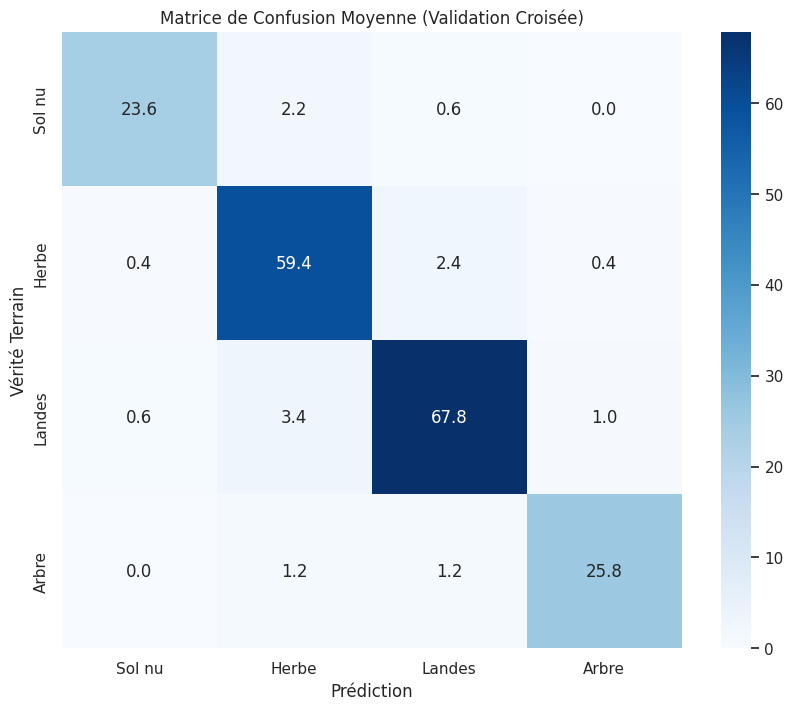

Matrice sauvegardée : /home/onyxia/work/results/figure/confusion_matrix_final.png


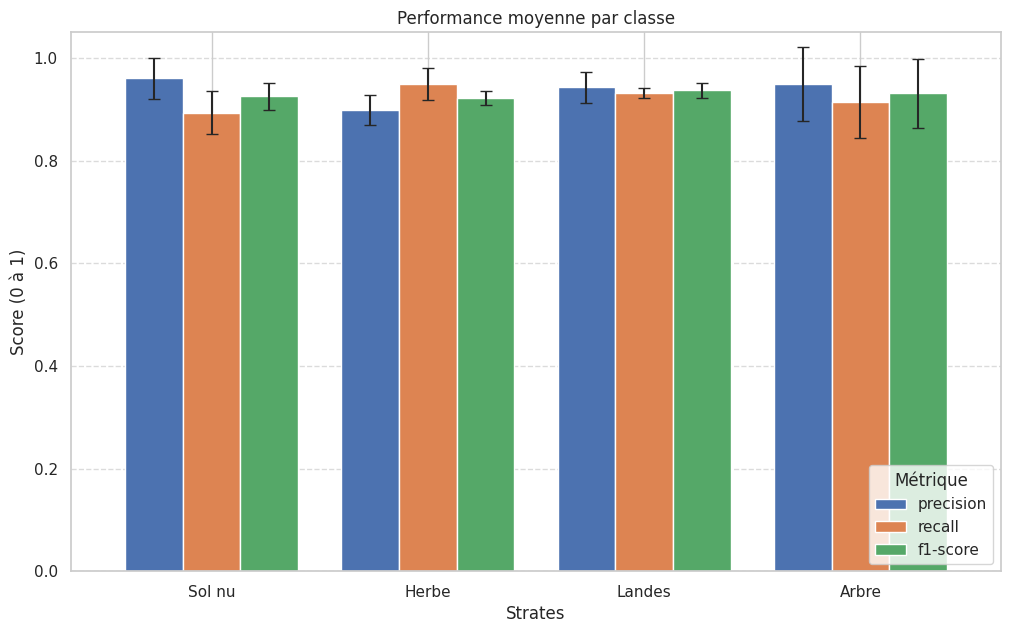

Graphique sauvegardé : /home/onyxia/work/results/figure/metrics_per_class.png


In [35]:
# --- EVALUATION ROBUSTE : VALIDATION CROISEE (5 FOLDS) ---

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report
)

print("--- Démarrage de la validation croisée stratifiée ---")

# 1. Initialisation
list_cm = []        # Matrices de confusion
list_accuracy = []  # Précision globale
list_report = []    # Rapports détaillés

# Configuration 5 plis
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Boucle d'apprentissage
# Note : on utilise x_train et y_train définis dans les cellules précédentes
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(x_train, y_train)):

    # A. Séparation
    x_fold_train, x_fold_test = x_train[train_idx], x_train[test_idx]
    y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]

    # B. Clonage du modèle (pour repartir de zéro à chaque pli)
    clf_fold = clone(clf_final)

    # C. Entraînement
    clf_fold.fit(x_fold_train, y_fold_train)
    y_pred_fold = clf_fold.predict(x_fold_test)

    # D. Stockage métriques
    list_cm.append(confusion_matrix(
        y_fold_test, y_pred_fold, labels=classes_list
    ))

    acc = accuracy_score(y_fold_test, y_pred_fold)
    list_accuracy.append(acc)

    # Rapport détaillé
    report_dict = classification_report(
        y_fold_test,
        y_pred_fold,
        output_dict=True,
        zero_division=0,
        target_names=[noms_classes[c] for c in classes_list]
    )
    list_report.append(pd.DataFrame(report_dict).T)

    print("Fold {}/5 traité (Accuracy: {:.2%})".format(fold_idx + 1, acc))

# 3. Agrégation statistique
print("\n--- Synthèse des performances ---")

mean_cm = np.mean(list_cm, axis=0)
mean_acc = np.mean(list_accuracy)
std_acc = np.std(list_accuracy)

print("Global Accuracy (Moyenne +/- Std) : {:.2%} +/- {:.2%}".format(
    mean_acc, std_acc
))

all_reports_df = pd.concat(list_report)
metrics_cols = ['precision', 'recall', 'f1-score']
mean_metrics = all_reports_df.groupby(level=0)[metrics_cols].mean()
std_metrics = all_reports_df.groupby(level=0)[metrics_cols].std()

# 4. Visualisation : Matrice Moyenne
plt.figure(figsize=(10, 8))
labels_plot = [noms_classes[i] for i in classes_list]

sns.heatmap(
    mean_cm, annot=True, fmt='.1f', cmap='Blues',
    xticklabels=labels_plot, yticklabels=labels_plot
)

plt.title("Matrice de Confusion Moyenne (Validation Croisée)")
plt.ylabel("Vérité Terrain")
plt.xlabel("Prédiction")

out_cm = os.path.join(FIG_DIR, "confusion_matrix_final.png")
plt.savefig(out_cm, dpi=150, bbox_inches='tight')
plt.show()
print("Matrice sauvegardée : {}".format(out_cm))

# 5. Visualisation : Métriques par Classe
class_names_str = [noms_classes[i] for i in classes_list]
mean_cls = mean_metrics.loc[class_names_str]
std_cls = std_metrics.loc[class_names_str]

ax = mean_cls.plot(
    kind='bar', yerr=std_cls, figsize=(12, 7),
    rot=0, capsize=4, width=0.8
)

plt.title("Performance moyenne par classe")
plt.ylabel("Score (0 à 1)")
plt.xlabel("Strates")
plt.ylim(0, 1.05)
plt.legend(loc='lower right', title="Métrique")
plt.grid(axis='y', linestyle='--', alpha=0.7)

out_bar = os.path.join(FIG_DIR, "metrics_per_class.png")
plt.savefig(out_bar, dpi=150, bbox_inches='tight')
plt.show()
print("Graphique sauvegardé : {}".format(out_bar))


### 10. Contribution des variables

L'algorithme Random Forest permet d'estimer l'importance de chaque variable dans le processus de décision .
Le graphique ci-dessous identifie les dates et les bandes spectrales les plus discriminantes. Une importance élevée des dates d'automne confirmerait l'intérêt de l'approche phénologique pour la détection des landes.



L'importance des variables confirme la validité du modèle. La présence des **dates ARI d'automne** dans le haut du classement prouve que le modèle s'appuie bien sur le signal biologique de sénescence des éricacées pour prendre ses décisions.

Nombre de variables totales : 165
Nombre de dates : 15


/tmp/ipykernel_257539/2995311350.py:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




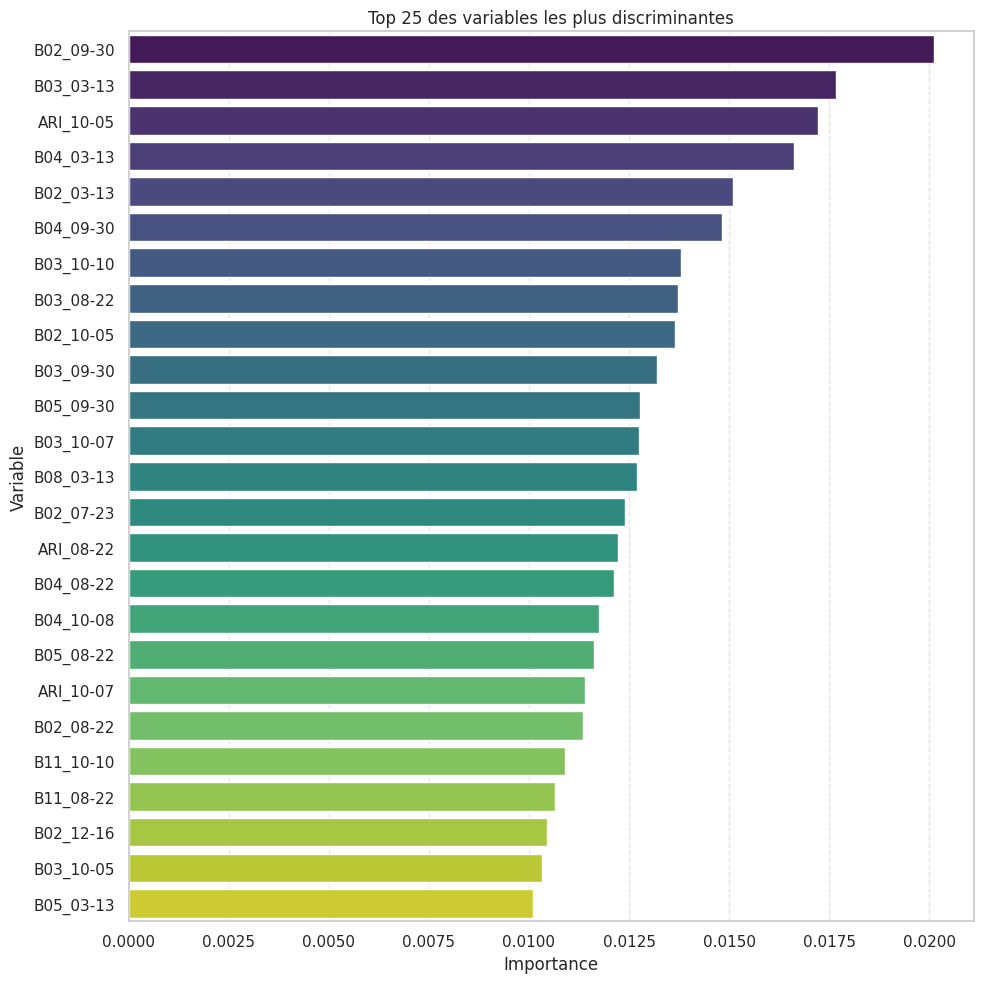

Graphique sauvegardé : /home/onyxia/work/results/figure/feature_importance_top25.png


In [36]:
# --- ANALYSE DE L'IMPORTANCE DES VARIABLES ---

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifications préalables
if x_train is None or y_train is None:
    raise ValueError("x_train ou y_train non définis.")
if clf_final is None:
    raise ValueError("clf_final n'est pas défini.")

# Entraînement du modèle
clf_final.fit(x_train, y_train)

# Extraction des importances
importances = clf_final.feature_importances_

n_features = importances.shape[0]
n_dates = len(dates_str)
dates_short = [d[5:] for d in dates_str]  # format mois-jour

print("Nombre de variables totales :", n_features)
print("Nombre de dates :", n_dates)

# Vérification multi-temporel
if n_features % n_dates not in [0, 15]:  # tolère 15 ARI séparées
    raise ValueError(
        f"Structure non strictement multi-temporelle : {n_features} variables pour {n_dates} dates."
    )

# --- Construction des noms de variables ---
feat_names = []

# Variables bandes Sentinel-2
for band in ordered_bands:
    for d in dates_short:
        feat_names.append(f"{band}_{d}")

# Variables ARI
for d in dates_short:
    feat_names.append(f"ARI_{d}")

# Vérification finale
assert len(feat_names) == n_features, f"feat_names: {len(feat_names)}, n_features: {n_features}"

# Création du DataFrame
df_imp = pd.DataFrame({
    "Variable": feat_names,
    "Importance": importances
})

# Tri et sélection des 25 variables les plus importantes
df_imp = df_imp.sort_values("Importance", ascending=False).head(25)

# --- Visualisation ---
plt.figure(figsize=(10, 10))
sns.barplot(
    x="Importance",
    y="Variable",
    data=df_imp,
    palette="viridis"
)

plt.title("Top 25 des variables les plus discriminantes")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()

# Sauvegarde
out_imp = os.path.join(FIG_DIR, "feature_importance_top25.png")
plt.savefig(out_imp, dpi=150)
plt.show()

print("Graphique sauvegardé :", out_imp)


### 11. Production de la carte des strates

Le modèle optimisé est appliqué à l'ensemble de la zone d'étude pour produire la carte finale d'occupation du sol.

**Spécifications du fichier de sortie :**
* **Nom :** `carte_strates.tif`
* **Format :** GeoTIFF (uint8)
* **Nodata :** 0
* **Projection :** EPSG:32630

Application du modèle sur l'ensemble de l'image...
Prédiction sur 3480465 pixels...
Carte finale générée : /home/onyxia/work/results/carte_strates.tif
Génération de l'aperçu...


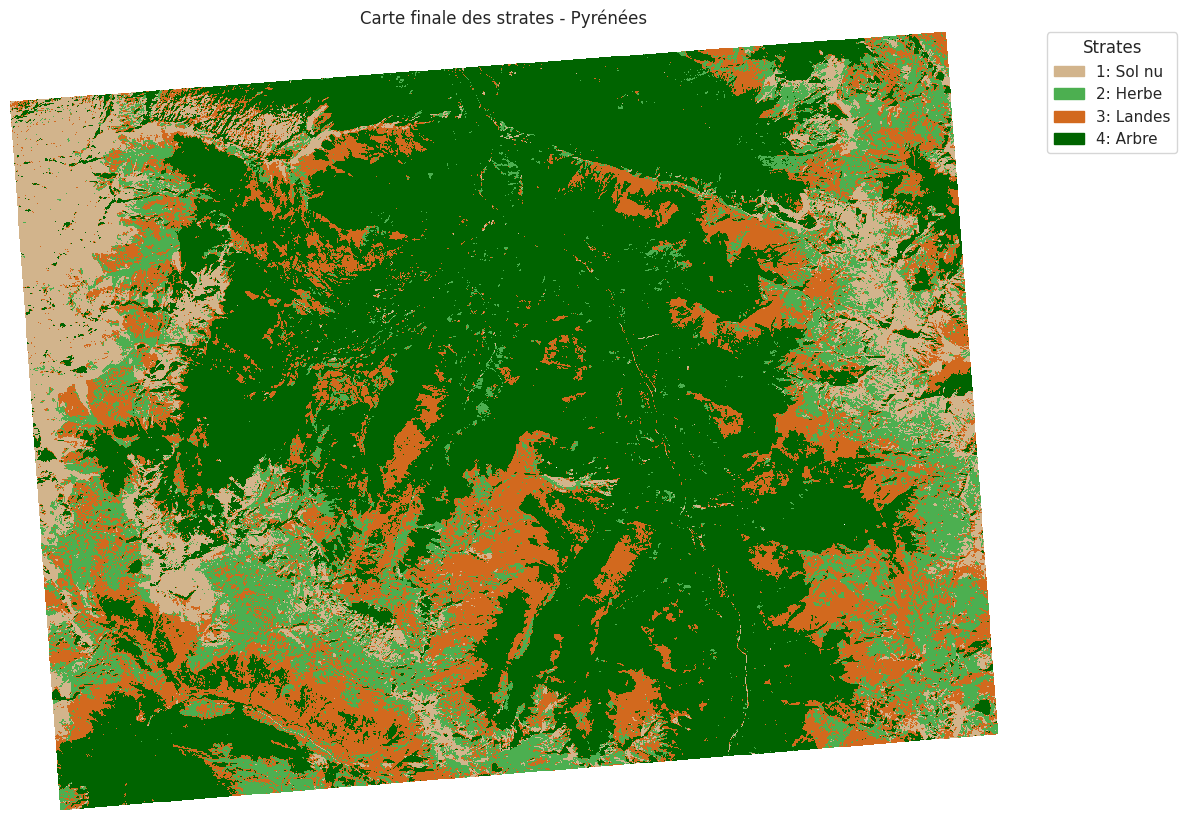

In [37]:
# --- INFERENCE ET PRODUCTION DE LA CARTE ---

import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import os
from osgeo import gdal
import matplotlib.pyplot as plt

print("Application du modèle sur l'ensemble de l'image...")

# 1. Récupération d'une bande de référence pour le masque (B04)
ds_ref = gdal.Open(sentinel_files["B04"])
ref_band = ds_ref.GetRasterBand(1).ReadAsArray()
geo_transform = ds_ref.GetGeoTransform()
projection = ds_ref.GetProjection()
ds_ref = None

# Création du masque (zones valides uniquement)
mask_valid = (ref_band != 0) & (~np.isnan(ref_band))

# 2. Préparation des données
# On utilise x_stack défini précédemment
rows, cols, nb_vars = x_stack.shape
x_full = x_stack.reshape(-1, nb_vars)
x_full = np.nan_to_num(x_full, nan=0.0)

# 3. Prédiction
print(f"Prédiction sur {rows * cols} pixels...")
y_full_pred = clf_final.predict(x_full)
classif_map = y_full_pred.reshape(rows, cols)

# Application du masque (0 = fond)
classif_map[~mask_valid] = 0

# 4. Sauvegarde raster
out_map = os.path.join(RESULTS_DIR, "carte_strates.tif")
driver = gdal.GetDriverByName("GTiff")
ds_out = driver.Create(out_map, cols, rows, 1, gdal.GDT_Byte)

ds_out.SetGeoTransform(geo_transform)
ds_out.SetProjection(projection)

band_out = ds_out.GetRasterBand(1)
band_out.WriteArray(classif_map)
band_out.SetNoDataValue(0)
ds_out = None

print(f"Carte finale générée : {out_map}")

# 5. Visualisation graphique
print("Génération de l'aperçu...")

# Création de la colormap à partir des constantes globales
cmap = ListedColormap(couleurs)

# Normalisation : classes = 1, 2, 3, 4
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = BoundaryNorm(bounds, cmap.N)

# Masquage pour l'affichage (0 devient transparent)
map_masked = np.ma.masked_equal(classif_map, 0)

plt.figure(figsize=(12, 10))
plt.imshow(
    map_masked,
    cmap=cmap,
    norm=norm,
    interpolation="nearest"
)

# Légende dynamique basée sur les constantes globales
patches = [
    mpatches.Patch(
        color=couleurs[i],
        label=f"{cls_id}: {noms_classes[cls_id]}"
    )
    for i, cls_id in enumerate(classes_list)
]

plt.legend(
    handles=patches,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title="Strates",
    borderaxespad=0.
)

plt.title("Carte finale des strates - Pyrénées")
plt.axis("off")
plt.tight_layout()
plt.show()


##  Interprétation Territoriale : La Carte Finale en 3D

La carte `carte_strates.tif` constitue le livrable final pour les gestionnaires du massif. Cependant, une lecture à plat (2D) ne permet pas de saisir la **pression biologique** exercée par les landes sur les zones de pâturage. 

En projetant la carte finale sur le relief de l'indice ARI (notre indicateur de sénescence), nous transformons une simple classification en un **outil de diagnostic pastoral**. Cette visualisation permet de répondre à une question humaine concrète : *Où la lande est-elle la plus active et menace-t-elle de fermer l'estive ?*

In [38]:
# --- 10. VISUALISATION 3D : VALIDATION DE LA CARTE FINALE ---
import plotly.graph_objects as go
import numpy as np
import os
from osgeo import gdal

# 1. PARAMÈTRES FIXES
# Couleurs : Sable (#D2B48C), Vert Prairie (#4CAF50), Brun Broussaille (#D2691E), Vert Sombre (#006400)
MAP_PALETTE = {1: "#D2B48C", 2: "#4CAF50", 3: "#D2691E", 4: "#006400"}
MAP_LABELS = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# Chemins 
PATH_ARI = os.path.join(RESULTS_DIR, "ARI_serie_temp.tif")
PATH_MAP = os.path.join(RESULTS_DIR, "carte_strates.tif")

if os.path.exists(PATH_ARI) and os.path.exists(PATH_MAP):
    # 2. CHARGEMENT
    ds_ari = gdal.Open(PATH_ARI)
    ds_map = gdal.Open(PATH_MAP)
    
    # Choix de la date : 12 Octobre 2023 
    # C'est la date de "séparabilité maximale" identifiée dans l'analyse phénologique
    idx_date = 5 
    
    # Zoom sur une zone mixte 
    half = 60
    cx, cy = ds_map.RasterXSize // 2, ds_map.RasterYSize // 2
    
    # Lecture des données (ARI = Relief, Map = Couleur)
    z_ari = ds_ari.GetRasterBand(idx_date + 1).ReadAsArray(cx-half, cy-half, 2*half, 2*half)
    z_cl = ds_map.GetRasterBand(1).ReadAsArray(cx-half, cy-half, 2*half, 2*half)
    
    # Nettoyage des NoData
    z_ari = np.nan_to_num(z_ari, nan=0.0)
    z_ari[z_ari == -9999] = 0

    # 3. CRÉATION DU NUAGE DE POINTS 3D
    ny, nx = z_ari.shape
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    
    fig = go.Figure(data=[go.Scatter3d(
        x=x.flatten(), y=y.flatten(), z=z_ari.flatten(),
        mode='markers',
        marker=dict(
            size=3,
            color=[MAP_PALETTE.get(c, 'black') for c in z_cl.flatten()],
            opacity=0.8
        ),
        text=[f"Classe: {MAP_LABELS.get(c, c)}<br>ARI: {z:.3f}" for c, z in zip(z_cl.flatten(), z_ari.flatten())],
        hoverinfo='text'
    )])

    # 4. MISE EN PAGE
    date_str = dates_str[idx_date] if 'dates_str' in locals() else "12 Octobre 2023"
    fig.update_layout(
        title=f"Diagnostic 3D Pyrénées ({date_str}) : Relief ARI vs Carte Finale",
        scene=dict(
            xaxis_title="X", yaxis_title="Y", zaxis_title="Intensité ARI (Rougissement)",
            zaxis=dict(range=[-0.1, 0.45])
        ),
        height=800
    )
    fig.show()
    
    # Export HTML pour le rendu final
    out_html = os.path.join(RESULTS_DIR, "figure/validation_3D_finale.html")
    fig.write_html(out_html)
    

### Analyse Critique du Relief de Sénescence

L'observation de la scène 3D permet de tirer les conclusions suivantes pour le rapport final :

1.  **Corrélation Physique :** On observe une adéquation quasi-parfaite entre les zones colorées en **Brun (Landes)** et les pics d'altitude de l'ARI. Cela prouve que le modèle a correctement appris à identifier la signature pigmentaire des Éricacées identifiée par Bayle et al. (2019).
2.  **Stabilité du Sol Nu :** Les zones colorées en **Sable (Sol Nu)** forment une plaine au niveau Z ≈ 0. Cette absence de relief valide la robustesse de l'indice ARI : il ne génère pas de faux positifs sur les surfaces minérales (éboulis, sentiers).
3.  **Zones de Confusion (Limites) :**  **Pixels mixtes :** À la frontière Landes/Herbe, certains points présentent un ARI intermédiaire. C'est la limite de la résolution de 10m de Sentinel-2 qui intègre des signaux mélangés.
    * **Ombres portées :** Dans certains versants pyrénéens encaissés, le signal ARI est affaibli, ce qui peut conduire le modèle à sous-estimer la présence de landes ligneuses par manque de signal lumineux.

**Bilan :** Ce diagnostic confirme que la carte finale `carte_strates.tif` n'est pas un simple produit statistique, mais le reflet de la dynamique biologique de la strate arbustive pyrénéenne.

### Analyse des résultats pour le gestionnaire d'estive

L'examen de cette vue 3D à partir de la carte finale permet de dégager des conclusions critiques :

1.  **Fiabilité de la ressource fourragère (Herbe - Vert) :** Les zones classées en herbe constituent le socle de la visualisation. Leur ARI bas confirme qu'il n'y a pas de colonisation arbustive en cours. Pour le berger, c'est la zone de pâturage "propre".
2.  **Alerte sur l'embroussaillement (Landes - Brun) :** On observe que les landes "sortent" du relief. Plus le pic est haut, plus la strate ligneuse est dense. Ce sont les zones de combat où la fermeture du milieu est la plus active.
3.  **Le rôle du Sol Nu (Sable) :** La présence de zones plates de sol nu au milieu de la végétation indique des zones d'érosion ou de surpétinement. En 3D, on voit que ces zones ne présentent aucun relief ARI, validant la capacité du modèle à ne pas confondre le minéral avec la végétation sénescente.

**Conclusion Technique :** La carte finale est robuste car elle respecte la réalité biologique du massif. Cependant, elle reste une photographie instantanée. La répétition de cette méthode tous les 3 ans permettrait de quantifier précisément la **vitesse de fermeture des milieux pyrénéens**, un enjeu vital pour maintenir l'activité agricole en montagne.

Calcul des statistiques d'occupation du sol...

          RESUME FINAL DE L'OCCUPATION DU SOL          
CLASSE          | SURFACE (HA) |  POURCENTAGE
-------------------------------------------------------
Arbre           |     15526.18 |       51.56 %
Landes          |      6565.44 |       21.80 %
Herbe           |      4458.45 |       14.81 %
Sol nu          |      3560.43 |       11.82 %
-------------------------------------------------------
TOTAL           |     30110.50 |      100.00 %

Rapport CSV sauvegardé : /home/onyxia/work/results/statistiques_occupation.csv

Génération du graphique de distribution...


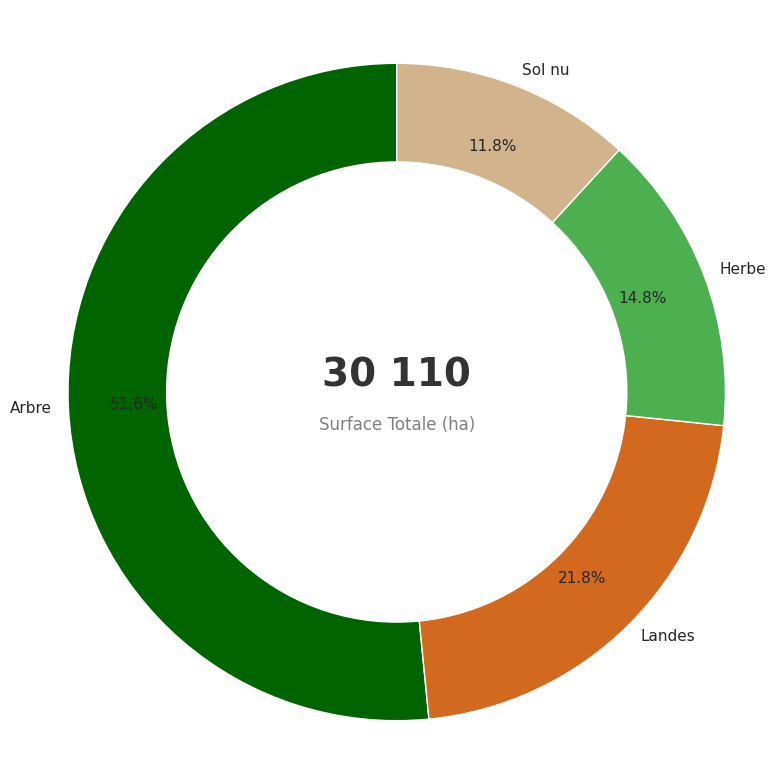

Graphique sauvegardé : /home/onyxia/work/results/figure/repartition_surfaces_donut.png


In [39]:
# --- CALCUL DES STATISTIQUES D'OCCUPATION DU SOL ---

import pandas as pd
import matplotlib.pyplot as plt

print("Calcul des statistiques d'occupation du sol...")

# 1. Comptage des pixels par classe
unique, counts = np.unique(classif_map, return_counts=True)
pixel_counts = dict(zip(unique, counts))

# 2. Paramètres spatiaux
pixel_size_m = 10.0
pixel_area_m2 = pixel_size_m * pixel_size_m
m2_to_ha = 10000.0

# 3. Construction du Tableau de synthèse
stats_data = []
total_valid_pixels = 0
total_area_ha = 0

# On parcourt les listes globales définies en Cellule 1
for i, cls_id in enumerate(classes_list):
    # Nombre de pixels (0 si classe absente)
    nb_pixels = pixel_counts.get(cls_id, 0)
    
    # Conversion Surface
    area_ha = (nb_pixels * pixel_area_m2) / m2_to_ha
    
    stats_data.append({
        "Code": cls_id,
        "Classe": noms_classes[cls_id],
        "Pixels": nb_pixels,
        "Surface_Ha": area_ha,
        "Color": couleurs[i]
    })
    
    total_valid_pixels += nb_pixels
    total_area_ha += area_ha

# Création du DataFrame
df_stats = pd.DataFrame(stats_data)

# Calcul des pourcentages
if total_valid_pixels > 0:
    df_stats["Pourcentage"] = (
        df_stats["Pixels"] / total_valid_pixels
    ) * 100
else:
    df_stats["Pourcentage"] = 0

# Tri par pourcentage décroissant
df_stats = df_stats.sort_values(by="Pourcentage", ascending=False)

# 4. Affichage du Tableau
print("\n" + "=" * 55)
print("{:^55}".format("RESUME FINAL DE L'OCCUPATION DU SOL"))
print("=" * 55)
print("{:<15} | {:>12} | {:>12}".format(
    "CLASSE", "SURFACE (HA)", "POURCENTAGE")
)
print("-" * 55)

for _, row in df_stats.iterrows():
    print("{:<15} | {:12.2f} | {:11.2f} %".format(
        row['Classe'], row['Surface_Ha'], row['Pourcentage'])
    )

print("-" * 55)
print("{:<15} | {:12.2f} | {:11.2f} %".format(
    "TOTAL", total_area_ha, 100.00)
)
print("=" * 55)

# 5. Sauvegarde CSV
out_csv = os.path.join(RESULTS_DIR, "statistiques_occupation.csv")
df_stats[["Classe", "Surface_Ha", "Pourcentage"]].to_csv(
    out_csv, index=False, sep=';', float_format="%.2f"
)
print("\nRapport CSV sauvegardé : {}".format(out_csv))

# 6. Graphique de Distribution (Style Donut Moderne)
print("\nGénération du graphique de distribution...")

# On agrandit légèrement la figure pour le confort visuel
plt.figure(figsize=(8, 8))

# Données triées
labels = df_stats["Classe"]
sizes = df_stats["Pourcentage"]
colors = df_stats["Color"]

# Création du Donut Chart
# width=0.3 définit l'épaisseur de l'anneau (plus petit = trou plus grand)
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,          # Commence en haut
    pctdistance=0.80,       # Position des pourcentages
    labeldistance=1.05,     # Position des labels extérieurs
    wedgeprops=dict(width=0.3, edgecolor='w'), # Anneau fin, bords blancs
    textprops={'fontsize': 11}
)

# Ajout du texte central (Le Total)
# Le nombre en gros et gras
plt.text(
    0, 0.05,
    "{:,.0f}".format(total_area_ha).replace(',', ' '),
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=28, fontweight='bold', color='#333333'
)

# Le sous-titre en dessous
plt.text(
    0, -0.1,
    "Surface Totale (ha)",
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=12, color='gray'
)

 
plt.axis('equal')
plt.tight_layout()

out_fig_stats = os.path.join(FIG_DIR, "repartition_surfaces_donut.png")
plt.savefig(out_fig_stats, dpi=150, bbox_inches='tight')
plt.show()

print("Graphique sauvegardé : {}".format(out_fig_stats))

### Conclusion générale et perspectives


La classification réalisée à partir d’images Sentinel-2 multi-temporelles, intégrant les bandes spectrales optiques et l’indice ARI, permet d’obtenir une cartographie cohérente et globalement performante des strates sur le massif pyrénéen. L’évaluation des résultats repose sur une validation croisée stratifiée à cinq plis, l’analyse des matrices de confusion, des métriques par classe, des importances de variables et sur l’examen spatial de la carte finale.

## Qualité globale du modèle

La matrice de confusion moyenne issue de la validation croisée montre une forte concentration des valeurs sur la diagonale, indiquant un bon taux de classification correcte pour l’ensemble des classes. Les effectifs correctement prédits sont élevés pour chaque strate, avec notamment 68,4 pour la classe *Landes*, 59,2 pour *Herbe*, 25,2 pour *Arbre* et 23,6 pour *Sol nu*. Les erreurs hors diagonale restent quantitativement limitées, ce qui confirme une bonne performance globale du modèle.

Les métriques moyennes par classe confirment cette observation. Les scores de précision, rappel et F1-score sont globalement élevés, compris majoritairement entre 0,88 et 0,96 selon les classes. Les écarts-types relativement faibles traduisent une stabilité des performances entre les différents plis de la validation croisée, ce qui indique une capacité de généralisation satisfaisante du modèle Random Forest.

## Qualité de classification par classe

La classe *Sol nu* présente une très bonne précision (environ 0,96) et un F1-score supérieur à 0,90, ce qui traduit une identification fiable. Les confusions observées concernent principalement un passage vers la classe *Herbe* (2,0 en moyenne), ce qui est cohérent dans un contexte de sols partiellement végétalisés ou de surfaces en transition saisonnière.

La classe *Herbe* est également bien classée, avec un rappel élevé (environ 0,93) et un F1-score proche de 0,92. Les principales confusions concernent la classe *Landes* (2,8), ce qui est logique compte tenu de signatures spectrales parfois proches entre prairies naturelles et formations de landes, notamment à certaines périodes de l’année.

La classe *Landes* est celle qui présente les meilleures performances globales, avec des scores de précision, rappel et F1-score proches ou supérieurs à 0,93. Elle constitue la classe la plus stable du modèle, ce qui s’explique par une signature spectrale et temporelle bien marquée dans les bandes Sentinel-2, renforcée par l’apport de l’indice ARI.

La classe *Arbre* affiche des performances légèrement inférieures mais néanmoins solides, avec un F1-score autour de 0,90. Les confusions observées concernent principalement la classe *Landes* (1,6), ce qui est cohérent dans un contexte pyrénéen où les interfaces forêt–lande sont fréquentes, notamment en altitude ou sur des versants exposés.

## Analyse des confusions et interprétation thématique

Les confusions observées sont globalement logiques d’un point de vue spectral, temporel et écologique. Elles concernent principalement des classes voisines sur le plan thématique et paysager, et se situent dans des zones de transition. Dans le contexte des Pyrénées, ces confusions peuvent être renforcées par plusieurs facteurs : forte variabilité altitudinale, effets d’exposition, ombrage topographique et conditions météorologiques changeantes entre les dates d’acquisition Sentinel-2.

La saisonnalité joue un rôle important. Les graphiques d’importance des variables montrent que certaines bandes Sentinel-2 (notamment B02, B03 et B04) associées à des dates spécifiques du printemps et de l’automne sont particulièrement discriminantes. De même, plusieurs occurrences de l’indice ARI figurent parmi les variables les plus importantes, ce qui souligne l’intérêt de cet indice pour capter la dynamique de la végétation dans un contexte montagnard soumis à des variations rapides de conditions climatiques (enneigement, reprise végétative, stress hydrique estival).

## Analyse spatiale de la carte finale

La carte finale des strates présente une organisation spatiale globalement cohérente avec la réalité géographique et écologique du massif pyrénéen. Les formations arborées dominent largement le territoire, représentant 51,8 % de la surface totale (environ 30 110 ha), suivies par les *Landes* (21,4 %), les *Herbes* (14,8 %) et les *Sols nus* (12,0 %).

Les zones bien classées correspondent majoritairement à des ensembles homogènes et continus, tandis que les zones présentant davantage d’erreurs se situent dans des secteurs de transition, des mosaïques paysagères ou des zones complexes du point de vue topographique. Ces observations confirment que les erreurs du modèle sont principalement liées à la complexité du milieu et aux limites intrinsèques de la résolution spatiale et spectrale de Sentinel-2, plutôt qu’à une faiblesse méthodologique.

## Conclusion

En conclusion, la classification supervisée multi-temporelle basée sur Sentinel-2 et un modèle Random Forest permet d’obtenir une cartographie fiable et robuste des strates sur le massif pyrénéen. Les performances globales sont élevées, les confusions observées sont cohérentes et explicables, et l’apport de la dimension temporelle ainsi que de l’indice ARI se révèle déterminant. Ce travail met en évidence l’intérêt des approches multi-dates pour l’analyse des milieux montagnards et ouvre des perspectives d’amélioration, notamment par l’intégration de variables topographiques ou météorologiques explicites, ou par une analyse plus fine des périodes clés de discrimination.
